# Workbook

In [2]:
# import necessary packages

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.listdir('/content/drive/My Drive/')

# audio_path = '/content/drive/My Drive/dataset/AUDIO_NEW/'

audio_path = 'dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

In [4]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)

    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

### mel spectrogram

In [5]:
# Load and process breathing data
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


In [6]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram

def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))

def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [52]:
def create_features(pos_directory, neg_directory, target_length):
    print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)
    
    positive_samples = len(labels)
    assert positive_samples == 172

    for file_path in sorted(neg_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

    assert len(labels) - positive_samples == 793

    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [51]:
# creating spectrogram, other features, and labels for breathing, cough, and speech

spectrograms_breathing, other_features_breathing, labels_breathing = create_features(pos_directory_breathing, neg_directory_breathing, 80000)

Creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 
Total number of positive samples:  172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Total number of negative:  793
Completed creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 


In [ ]:
spectrograms_cough, other_features_cough, labels_cough = create_features(pos_directory_cough, neg_directory_cough, 80000)

Creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 
Total number of positive samples:  172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Completed creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 
Total number of negative:  793


In [49]:
spectrograms_speech, other_features_speech, labels_speech = create_features(pos_directory_speech, neg_directory_speech, 80000)

Creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 
Total number of positive samples:  172
Completed creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 
Total number of negative:  793


In [53]:
# Combine spectrograms, other features, and labels for each participant
all_spectrograms = []
all_other_features = []
all_labels = []

# Assuming all lists are sorted in the same order and correspond to the same participants
for i in range(len(spectrograms_breathing)):  # Iterate over participants
    # Combine spectrograms for breathing, coughing, and speech along the time axis
    combined_spectrogram = np.concatenate(
        [spectrograms_breathing[i], spectrograms_cough[i], spectrograms_speech[i]], axis=-1
    )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features = np.concatenate(
        [other_features_breathing[i], other_features_cough[i], other_features_speech[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label = labels_breathing[i]  # You can use any of the label lists since they are consistent

    # Append combined data to the final lists
    all_spectrograms.append(combined_spectrogram)
    all_other_features.append(combined_other_features)
    all_labels.append(label)

# Convert to NumPy arrays
all_spectrograms = np.array(all_spectrograms)
all_other_features = np.array(all_other_features)
all_labels = np.array(all_labels)

# Flatten spectrograms and combine with other features
all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)
X_combined = np.hstack([all_spectrograms_flattened, all_other_features])


In [ ]:
# Shazia's Code
# all_spectrograms = spectrograms_cough + spectrograms_speech + spectrograms_breathing
# all_other_features = other_features_cough + other_features_speech + other_features_breathing
# all_labels = labels_cough + labels_speech + labels_breathing

# # Convert to NumPy arrays
# all_spectrograms = np.array(all_spectrograms)
# all_other_features = np.array(all_other_features)
# all_labels = np.array(all_labels)
# all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)

In [ ]:
# X_combined = np.hstack([all_spectrograms_flattened, all_other_features])

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, all_labels, test_size=0.2, stratify=all_labels)

In [14]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
# X_train_numpy = np.array(X_train)
# X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

# print(f"Original shape: {X_train_numpy.shape}")
# print(f"Flattened shape: {X_train_flattened.shape}")

We used the `SMOTEENN` function in the imblearn library to handle imbalanced datasets by oversampling `1`, the minority class and remove noisy samples. 

In [59]:
#!pip install imbalanced-learn
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [40]:
# Print resampled class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Original class distribution: Counter({np.int64(0): 1903, np.int64(1): 413})
Resampled class distribution: Counter({np.int64(1): 1870, np.int64(0): 399})


In [17]:
# # Reshape back to original format after resampling
# X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

# print(f"Reshaped back to original format: {X_resampled.shape}")

In [71]:
# num_time_frames will change depending on the audio_type 

num_mel_bands = 128
num_time_frames = 626  # Original time frames per spectrogram
num_spectrogram_features = num_mel_bands * num_time_frames * 3

In [72]:
# Separate resampled spectrograms and other features for X_train_resampled
spectrograms_resampled = X_train_resampled[:, :num_spectrogram_features]
other_features_resampled = X_train_resampled[:, num_spectrogram_features:]

In [73]:
# Reshape the flattened spectrograms back to their original shape (128x626)
spectrograms_resampled_reshaped = spectrograms_resampled.reshape(
    spectrograms_resampled.shape[0], num_mel_bands, num_time_frames * 3, 1
)


In [74]:
# Separate into breathing, coughing, and speech
spectrograms_breathing_resampled = spectrograms_resampled_reshaped[:, :, :num_time_frames, :]
spectrograms_coughing_resampled = spectrograms_resampled_reshaped[:, :, num_time_frames:num_time_frames*2, :]
spectrograms_speech_resampled = spectrograms_resampled_reshaped[:, :, num_time_frames*2:, :]

# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_breathing_resampled.shape)
print("Coughing Spectrogram Shape:", spectrograms_coughing_resampled.shape)
print("Speech Spectrogram Shape:", spectrograms_speech_resampled.shape)


Breathing Spectrogram Shape: (724, 128, 626, 1)
Coughing Spectrogram Shape: (724, 128, 626, 1)
Speech Spectrogram Shape: (724, 128, 626, 1)


In [22]:
# Optionally add a channel dimension for CNN input (e.g., shape: [samples, 128, 626, 1])
#spectrograms_resampled_reshaped = np.expand_dims(spectrograms_resampled_reshaped, axis=-1)

In [75]:
spectrograms_resampled_reshaped.shape

(724, 128, 1878, 1)

In [76]:
other_features_resampled.shape

(724, 6)

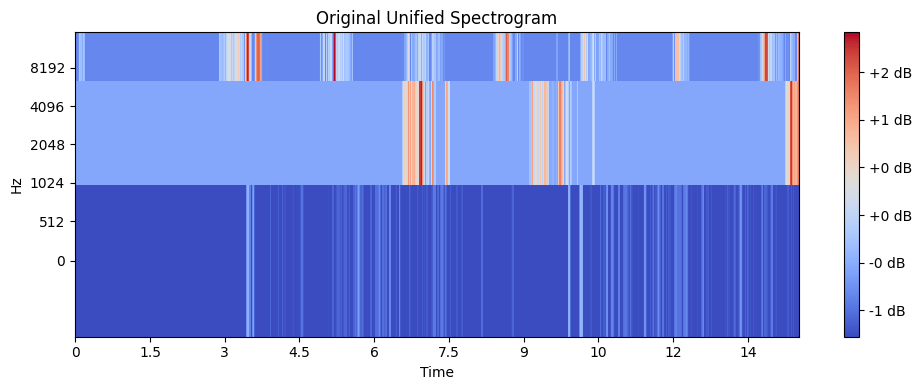

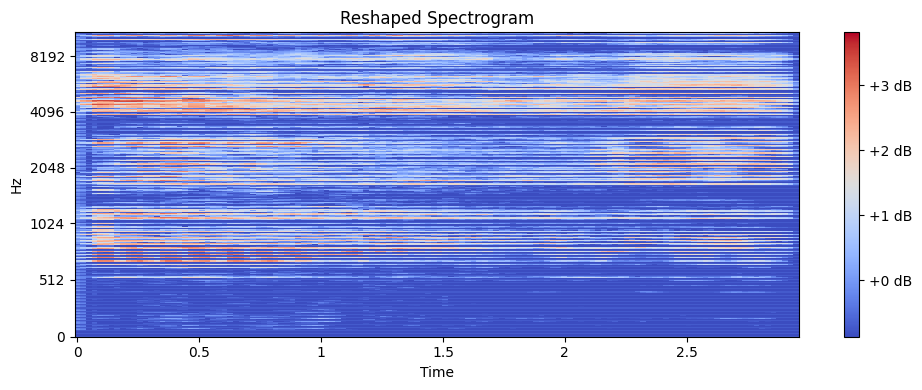

In [78]:
import random
import matplotlib.pyplot as plt
import librosa.display

# Function to plot spectrogram
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    # Remove channel dimension if present for visualization
    if spectrogram.shape[-1] == 1:
        spectrogram = spectrogram.squeeze(-1)
    librosa.display.specshow(spectrogram.T, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming 'original_spectrogram' is your original unflattened spectrogram
# and 'reshaped_spectrogram' is your reshaped version after processing

# Plot original spectrogram (before flattening)
plot_spectrogram(all_spectrograms[0][0], "Original Unified Spectrogram")

plot_spectrogram(spectrograms_resampled_reshaped[100], "Reshaped Spectrogram")



In [26]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :num_spectrogram_features]
other_features_test = X_test[:, num_spectrogram_features:]
spectrograms_test_reshaped = spectrograms_test.reshape(spectrograms_test.shape[0], 128, 626, 1)

In [27]:
y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

In [28]:
# y_resampled = np.array(y_resampled)

### Single input model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D

In [30]:
model = Sequential()
model.add(Input(shape=(128,626,1)))

# First Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Reduces spatial dimensions by half

# Second Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Third Conv2D layer followed by MaxPooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Fourth Conv2D layer followed by MaxPooling (new)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Flatten and Dense layers
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 624, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 312, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 310, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 155, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 153, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 76, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 37, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,065 (133.07 KB)

 Trainable params: 34,065 (133.07 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Reshape X_train_spectrograms to have the same shape as the spectrograms_resampled_reshaped
# using num_spectrogram_features, which is 128 * 626 in this case.
# X_train_spectrograms = X_train[:, :num_spectrogram_features]  # Extract spectrogram features from training data
# X_train_spectrograms_reshaped = X_train_spectrograms.reshape(X_train_spectrograms.shape[0], 128, 626, 1)  # Reshape to (samples, 128, 626, 1)


# hist = model.fit(
#     X_train_spectrograms_reshaped,  # Pass the reshaped TRAINING spectrograms as input
#     y_train,  # Labels
#     batch_size=16,
#     verbose=2,
#     epochs=20,
#     validation_split=0.1
# )
hist = model.fit(
    X_train_resampled[:, :num_spectrogram_features].reshape(-1, 128, 626, 1),  # Mel spectrograms
    y_train_resampled,
    batch_size=8,
    verbose=2,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
250/250 - 70s - loss: 0.4784 - recall: 1.0000 - precision: 0.8208 - val_loss: 0.2032 - val_recall: 1.0000 - val_precision: 1.0000 - 70s/epoch - 281ms/step
Epoch 2/10
250/250 - 65s - loss: 0.4452 - recall: 1.0000 - precision: 0.8208 - val_loss: 0.1918 - val_recall: 1.0000 - val_precision: 1.0000 - 65s/epoch - 262ms/step
Epoch 3/10
250/250 - 66s - loss: 0.4105 - recall: 0.9817 - precision: 0.8312 - val_loss: 0.2876 - val_recall: 0.9507 - val_precision: 1.0000 - 66s/epoch - 266ms/step
Epoch 4/10
250/250 - 66s - loss: 0.3659 - recall: 0.9713 - precision: 0.8546 - val_loss: 0.2779 - val_recall: 0.9193 - val_precision: 1.0000 - 66s/epoch - 262ms/step
Epoch 5/10
250/250 - 65s - loss: 0.3466 - recall: 0.9524 - precision: 0.8707 - val_loss: 0.0726 - val_recall: 0.9910 - val_precision: 1.0000 - 65s/epoch - 260ms/step
Epoch 6/10
250/250 - 66s - loss: 0.3283 - recall: 0.9451 - precision: 0.8827 - val_loss: 0.0659 - val_recall: 0.9955 - val_precision: 1.0000 - 66s/epoch - 262ms/step
Epoc

### Fit Model, View Loss and KPI Plots

In [37]:
# Assuming 'num_spectrogram_features' is defined earlier

# Extract and reshape spectrograms
X_test_spectrograms = X_test[:, :num_spectrogram_features]
X_test_spectrograms_reshaped = X_test_spectrograms.reshape(X_test_spectrograms.shape[0], 128, 626, 1)

# Extract other features
X_test_other_features = X_test[:, num_spectrogram_features:]

# Make predictions
y_pred = model.predict(X_test_spectrograms_reshaped)


19/19 [==============================] - 6s 322ms/step


In [38]:
y_pred_binary = (y_pred > 0.99).astype(int)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_binary)

In [40]:
len(y_test)

579

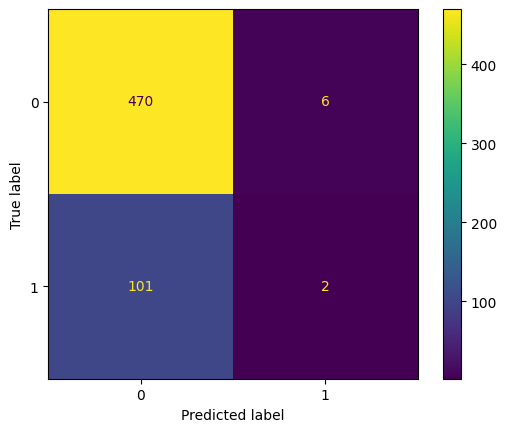

In [41]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

### Multi-input model

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input = Input(shape=(128, 626, 1), name='mel_spectrogram')

# Define CNN sub-network for Mel spectrogram
x = Conv2D(16, (3,3), activation='relu')(mel_input)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = GlobalAveragePooling2D()(x)

# Define input for other features (e.g., zero-crossing rate and spectral centroid)
other_input = Input(shape=(2,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([x, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [43]:
X_train_spectrograms = spectrograms_resampled_reshaped
X_train_others = other_features_resampled
y_train = y_train_resampled

In [44]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_spectrogram (InputLaye  [(None, 128, 626, 1)]        0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_4 (Conv2D)           (None, 126, 624, 16)         160       ['mel_spectrogram[0][0]']     
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 63, 312, 16)          0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                              

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout
from sklearn.model_selection import train_test_split

# ... (Your previous code for data loading and preprocessing) ...

# Split your data into training and validation sets
X_train_combined = np.hstack([all_spectrograms_flattened, all_other_features])
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, all_labels, test_size=0.1, stratify=all_labels, random_state=42)

# Resample the training data
smote_enn = SMOTEENN(random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Separate and reshape spectrograms for training and validation data
num_spectrogram_features = 128 * 626
X_train_spectrograms = X_train_resampled[:, :num_spectrogram_features].reshape(-1, 128, 626, 1)
X_train_others = X_train_resampled[:, num_spectrogram_features:]
X_val_spectrograms = X_val[:, :num_spectrogram_features].reshape(-1, 128, 626, 1)
X_val_others = X_val[:, num_spectrogram_features:]

# ... (Your model definition code) ...

# Compile the model with ordered metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Fit the model using validation_data
history = model.fit(
    [X_train_spectrograms, X_train_others],
    y_train_resampled,
    validation_data=([X_val_spectrograms, X_val_others], y_val),
    verbose=2,
    epochs=20,
    batch_size=16
)

Epoch 1/20
160/160 - 88s - loss: 0.2469 - accuracy: 0.8866 - recall_3: 0.9471 - precision_3: 0.9189 - val_loss: 1.4615 - val_accuracy: 0.4103 - val_recall_3: 0.8846 - val_precision_3: 0.2180 - 88s/epoch - 548ms/step
Epoch 2/20
160/160 - 85s - loss: 0.2410 - accuracy: 0.8944 - recall_3: 0.9551 - precision_3: 0.9208 - val_loss: 1.7098 - val_accuracy: 0.3552 - val_recall_3: 0.9038 - val_precision_3: 0.2052 - 85s/epoch - 533ms/step
Epoch 3/20
160/160 - 85s - loss: 0.2218 - accuracy: 0.8995 - recall_3: 0.9528 - precision_3: 0.9282 - val_loss: 1.1645 - val_accuracy: 0.4690 - val_recall_3: 0.7308 - val_precision_3: 0.2135 - 85s/epoch - 529ms/step
Epoch 4/20
160/160 - 87s - loss: 0.2318 - accuracy: 0.8948 - recall_3: 0.9485 - precision_3: 0.9266 - val_loss: 1.6376 - val_accuracy: 0.3621 - val_recall_3: 0.9038 - val_precision_3: 0.2070 - 87s/epoch - 544ms/step
Epoch 5/20
160/160 - 85s - loss: 0.2237 - accuracy: 0.8995 - recall_3: 0.9565 - precision_3: 0.9251 - val_loss: 1.0298 - val_accuracy: 0

In [1]:
X_train_spectrograms.shape

NameError: name 'X_train_spectrograms' is not defined

In [47]:
X_train_others

array([[1.89086137e-01, 2.07349165e+03],
       [1.21557151e-01, 1.10675218e+03],
       [9.12370621e-02, 1.27525876e+03],
       ...,
       [3.69502665e-01, 2.66839273e+03],
       [1.77108496e-01, 2.00960918e+03],
       [2.84412101e-01, 1.80930920e+03]])

In [48]:
y_pred_train = model.predict([X_train_spectrograms, X_train_others])

80/80 [==============================] - 28s 352ms/step


In [49]:
y_pred_train_binary = (y_pred_train > 0.99).astype(int)

In [51]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train_resampled, y_pred_train_binary)


print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.5208006279434851


In [52]:
accuracy_train

0.5208006279434851

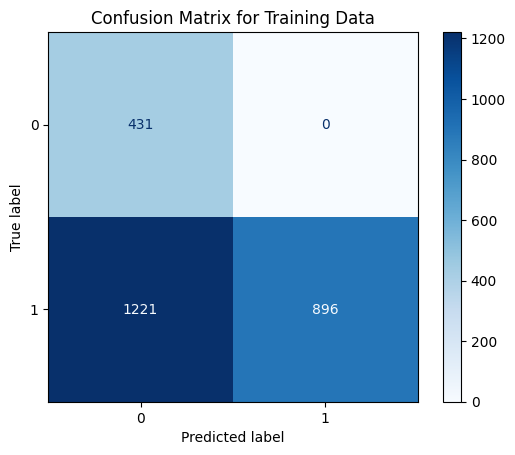

In [54]:
cm = confusion_matrix(y_train_resampled, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [55]:
y_pred_test = model.predict([spectrograms_test_reshaped, other_features_test])

19/19 [==============================] - 7s 351ms/step


In [56]:
y_pred_test_binary = (y_pred > 0.99).astype(int)

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test_binary)

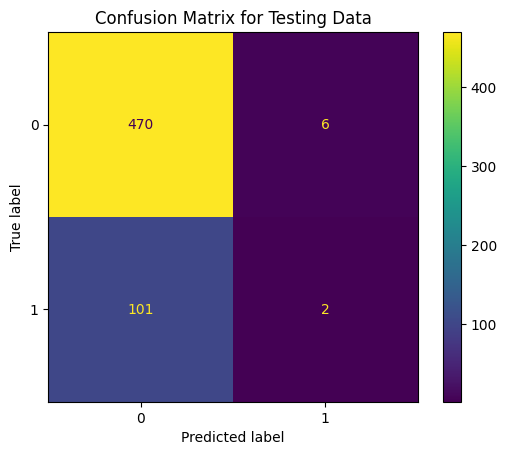

In [58]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [59]:
from sklearn.metrics import accuracy_score

accuracy_test = accuracy_score(y_test, y_pred_test_binary)

In [61]:
accuracy_test

0.8151986183074266